<a href="https://colab.research.google.com/github/pjconnell/OCR-Translator/blob/main/OCR_for_Foreign_Language_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will walk you through a two step process of: 


> (i) using Optical Character Recognition (OCR) from Google's pytesseract to convert a foreign-language PDF file to .txt, and



> (ii) using Google Translate's API to convert that .txt file to English.


First, make sure that you've set up the appropriate "Input PDFs" and "Output TXTs" files in the same folder in Google Drive where this Colab Notebook is saved. Please refer to the readme on GitHub for a step-by-step guide (https://github.com/pjconnell/OCR-Translator/blob/main/README.md).


Next, we'll have to link your Google Drive to this colab notebook. Run the following block of code (mouse over the upper left-hand side of the cell and click the "play" button that appears) and follow the instructions (it will give you a link to access a security code to paste back in).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




Before getting started, make sure you've uploaded the PDF you want to translate into the "Input PDFs" folder on Google Drive. You should see it on the left-side panel here (you might have to click the file icon to see the document tree - also try clicking the "refresh" button (middle icon above column) if you don't see the files right away):

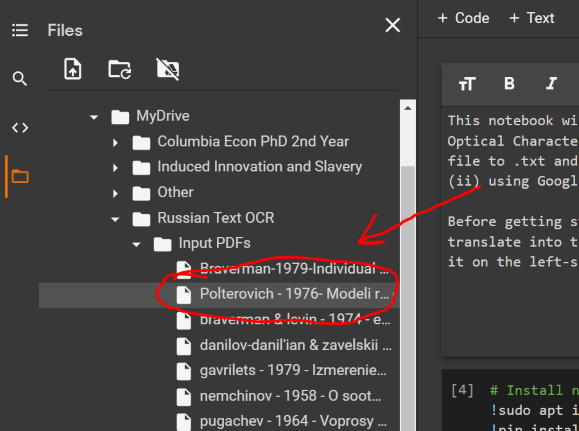


Next, we will load the software needed to run the python code below. To run this cell, click on the "run" icon in the upper left-hand corner of the cell, per the picture below. This cell only needs to be run once, but it may take a few minutes. Once the "play" button returns, continue to the next cell below all the readout.

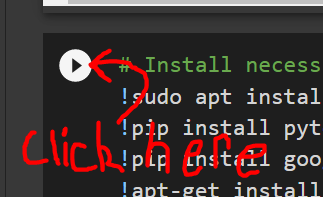

In [ ]:
# Install necessary dependencies
!sudo apt install tesseract-ocr-all
!pip install pytesseract
!pip install googletrans==4.0.0-rc1
!apt-get install poppler-utils 
!pip install pdf2image

# Import libraries 
from PIL import Image 
import pytesseract 
from pdf2image import convert_from_path 
from tqdm import tqdm
from googletrans import Translator
import numpy as np
import pandas as pd
import time

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-afr tesseract-ocr-amh tesseract-ocr-ara
  tesseract-ocr-asm tesseract-ocr-aze tesseract-ocr-aze-cyrl tesseract-ocr-bel
  tesseract-ocr-ben tesseract-ocr-bod tesseract-ocr-bos tesseract-ocr-bre
  tesseract-ocr-bul tesseract-ocr-cat tesseract-ocr-ceb tesseract-ocr-ces
  tesseract-ocr-chi-sim tesseract-ocr-chi-sim-vert tesseract-ocr-chi-tra
  tesseract-ocr-chi-tra-vert tesseract-ocr-chr tesseract-ocr-cos
  tesseract-ocr-cym tesseract-ocr-dan tesseract-ocr-deu tesseract-ocr-div
  tesseract-ocr-dzo tesseract-ocr-ell tesseract-ocr-eng tesseract-ocr-enm
  tesseract-ocr-epo tesseract-ocr-est tesseract-ocr-eus tesseract-ocr-fao
  tesseract-ocr-fas tesseract-ocr-fil tesseract-ocr-fin tesseract-ocr-fra
  tesseract-ocr-frk tesseract-ocr-frm tesseract-ocr-fry tesseract-ocr-gla
  tesseract-ocr-gle tesseract-ocr-glg tesserac

Now we can create the python functions that will convert our images to text and then translate it. To do that, run the following cell (you only need to do so once - it should complete almost immediately).

As a troubleshooting note, please ensure that the "sheet_url" variable is pointed toward the correct address for where you've saved the "Language Key" spreadsheet. For guidance on how to import Google Sheets into Pandas dataframs (as this code does below), please refer to: https://towardsdatascience.com/read-data-from-google-sheets-into-pandas-without-the-google-sheets-api-5c468536550.

In [ ]:
# Load language key so we have the right codes to feed into Tesseract and Google Trans
sheet_url = "https://docs.google.com/spreadsheets/d/1MLDa7-x7csvrTuO6IJGiz2839h3TA25ICDHX_hG4frU/edit#gid=0"
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
key =pd.read_csv(url_1)

# Create function to do the image to text conversion

def img_to_txt(PDF_file,destination_file,code_3):
    print("")
    print("Starting OCR - the process may take a couple minutes per page")
    ''' 
    Part #1 : Converting PDF to images 
    '''
    # Store all the pages of the PDF in a variable 
    pages = convert_from_path(PDF_file, 500) 

    # Counter to store images of each page of PDF to image 
    image_counter = 1

    # Iterate through all the pages stored above 
    for page in tqdm(pages): 
        filename = "page_"+str(image_counter)+".jpg"

        # Save the image of the page in system 
        page.save(filename, 'JPEG') 

        # Increment the counter to update filename 
        image_counter = image_counter + 1

    ''' 
    Part #2 - Recognizing text from the images using OCR 
    '''
    # Set tesseract to an executable command line PATH
    pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

    # Variable to get count of total number of pages 
    filelimit = image_counter-1

    # Creating a text file to write the output 
    outfile = "/content/drive/MyDrive/Foreign Text OCR/Output TXTs/"+destination_file+"_"+code_3+".txt"

    # Open the file in append mode so that  
    # All contents of all images are added to the same file 
    f = open(outfile,'w+', encoding='utf-8') 

    # Iterate from 1 to total number of pages 
    for i in tqdm(range(1, filelimit + 1)): 

        filename = "page_"+str(i)+".jpg"

        # Recognize the text as string in image using pytesserct 
        text = str(((pytesseract.image_to_string(Image.open(filename),lang=f'eng+{code_3}', config='--psm 1'))))

        # The recognized text is stored in variable text 
        # Any string processing may be applied on text 
        # Here, basic formatting has been done: 
        # In many PDFs, at line ending, if a word can't 
        # be written fully, a 'hyphen' is added. 
        # The rest of the word is written in the next line 
        # To remove this, we replace every '-\n' to ''.
        # For smoothness in translating, we remove the
        # line breaks except for spacing between paragraphs. 
        text = text.replace('-\n', '')
        text = text.replace('\n\n', '\r')
        text = text.replace('\n', ' ')
        text = text.replace('\r', '\n\n')     

        # Finally, write the processed text to the file. 
        f.write(text) 

    # Close the file after writing all the text. 
    f.close()

# create function to do the translation

def translate_doc(destination_file,code_2):
    '''
    source_file is the file name for the .txt foreign language doc to be translated
    destination_file is the file name you want to save the .txt English translation to
    code_2 is the two letter country code for the source language
    '''
    print("")
    print("Starting translation")
    
    source_file = destination_file+"_"+code_3+".txt" # to line up with img_to_txt func above
    destination_file = destination_file+"_eng"+".txt"
    
    translator = Translator() # create object for googletrans

    f = open("/content/drive/MyDrive/Foreign Text OCR/Output TXTs/"+source_file,mode='r',encoding="utf8") # load the file to be translated
    contents = f.read()

    temp="" # initialize temp variable to store text from each translation

    num_iter=int(np.ceil(len(contents)/5000)) # determine number of iterations (you get 5000 chars at a time)

    for i in tqdm(range(num_iter)):

        # set string indices to call for translation
        start = i*4999
        stop = start+5000

        # this does the actual translating
        result = translator.translate(contents[start:stop], dest='en', src=code_2)

        # concatenate translation to the temp variable
        temp = temp+result.text

        # sleep for 1 second so we don't get blocked from googletranslate
        time.sleep(1)

    # write the results to a new file
    with open("/content/drive/MyDrive/Foreign Text OCR/Output TXTs/"+destination_file, 'w', encoding="utf8") as f:
        f.write(temp)
    print("")
    print("Process completed! TXT files are saved in Google Drive.")

Now that the functions are set up, we can run them to do the OCR / translation. 

Run the cell below, and you will be prompted to paste the path for your input file. You can copy that by right-clicking on the file on the pane to your left and selecting "copy path."

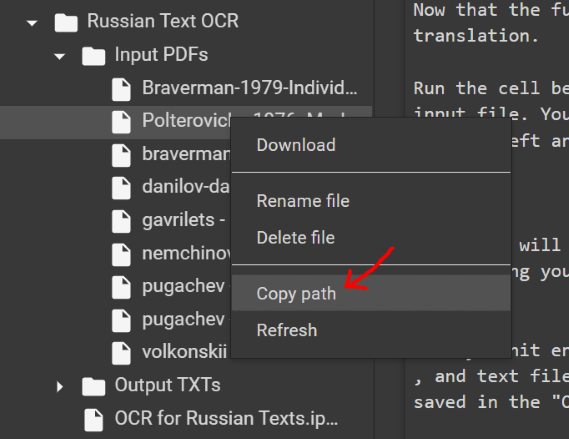

Next, you will be asked to provide a name for the output file. This can be anything you want. 

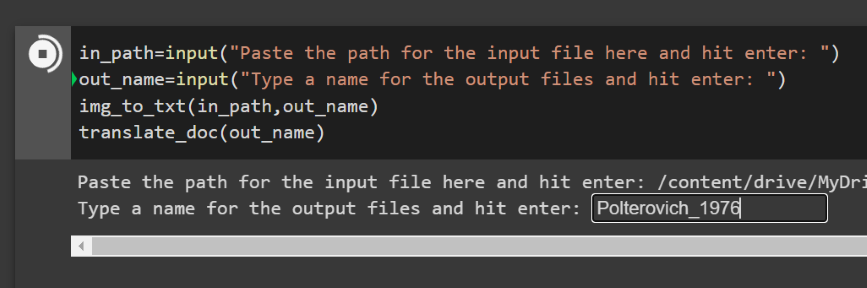

Once you hit enter, the entire process will run (both OCR and translation), and text files of the Russian OCR and the Google translation will be saved in the "Output TXTs" file on Google Drive.

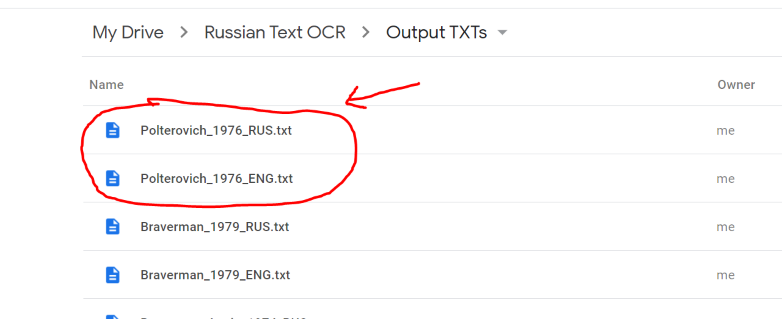


**Note:** this cell can be run as many times as you want. So, if you have multiple PDFs you would like to convert, wait until the first is finished (you'll see a message: "Process completed! TXT files are saved in Google Drive.") then run this cell again providing the path for your next PDF, etc.

In [ ]:
# Finally, ask for the source language and check that it is supported
lang=input("Type the name of the source language (e.g., 'Russian') and hit enter: ")
try:
    # get language codes from the key
    code = key[key['language']==lang].reset_index()
    code_3 = code['3_code'][0]
    code_2 = code['2_code'][0]

    # ask for file names an initiate processing
    print("")
    in_path=input("Paste the path for the input file here and hit enter: ")
    print("")
    out_name=input("Type a name for the output files and hit enter: ")
    img_to_txt(in_path,out_name,code_3)
    translate_doc(out_name,code_2)
except:
  print("That language is not supported. Please verify it was entered correctly.")



Type the name of the source language (e.g., 'Russian') and hit enter: Russian

Paste the path for the input file here and hit enter: /content/drive/MyDrive/Foreign Text OCR/Input PDFs/braverman - 1972 - model' proizvostva s neranovesnymi tsenami.pdf

Type a name for the output files and hit enter: Braverman_1972

Starting OCR - the process may take a couple minutes per page


  0%|          | 0/9 [00:00<?, ?it/s]


Starting translation


100%|██████████| 9/9 [00:13<00:00,  1.55s/it]


Process completed! TXT files are saved in Google Drive.
